In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random, os, math, time, pickle
from datetime import datetime
from networkx.utils import py_random_state
from networkx.algorithms import community
from scipy.optimize import fsolve, minimize
from math import comb  # For computing combinations
from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec  # Import GridSpec
from matplotlib import colormaps

 
# 0=male and 1=female.

The edge list provides the structure of the social network, while the gender file allows for the analysis of gender-based interactions within the network. This dataset is useful for studying how homophily (the tendency to connect with similar individuals) and triadic closure (forming connections through mutual friends) shape social network dynamics.

Number of 2-cliques: 208463
Number of 3-cliques: 67930
Number of 4-cliques: 25651
Number of 5-cliques: 10472
Number of 6-cliques: 4293
Number of 7-cliques: 1888
Number of 8-cliques: 824
Number of 9-cliques: 357
Number of 10-cliques: 116
Number of 11-cliques: 71
Number of 12-cliques: 7
Number of 13-cliques: 15
Number of 14-cliques: 2
Subgraph for cliques of size 2 has 150914 nodes and 208463 edges.
Subgraph for cliques of size 3 has 88011 nodes and 163640 edges.
Subgraph for cliques of size 4 has 45202 nodes and 105826 edges.
Subgraph for cliques of size 5 has 22201 nodes and 63416 edges.
Subgraph for cliques of size 6 has 9682 nodes and 33071 edges.
Subgraph for cliques of size 7 has 4535 nodes and 18009 edges.
Subgraph for cliques of size 8 has 1938 nodes and 8981 edges.
Subgraph for cliques of size 9 has 698 nodes and 3727 edges.
Subgraph for cliques of size 10 has 320 nodes and 1797 edges.
Subgraph for cliques of size 11 has 191 nodes and 1209 edges.
Subgraph for cliques of size 12 

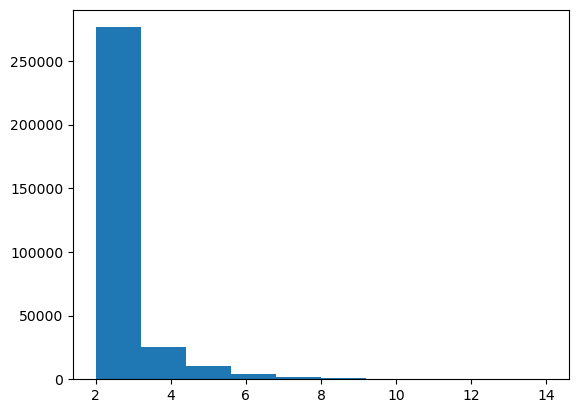

In [2]:
# Step 1: Read the edge list to create the network
edge_list_file = 'lastfm.edg'
G = nx.read_edgelist(edge_list_file, nodetype=int)

# Step 2: Read the gender attributes
gender_file = 'lastfm_genders.txt'
gender_dict = {}

with open(gender_file, 'r') as f:
    for line in f:
        node, gender = line.strip().split()
        gender_dict[int(node)] = int(gender)

# Step 3: Assign colors to nodes based on the gender attribute
Nr = 0
color_map = []
for node in G.nodes():
    if gender_dict.get(node) == 1:
        color_map.append('blue')  # Gender 1
        Nr += 1
    else:
        color_map.append('red')   # Gender 0
        

# Step 3: Assign colors directly to nodes based on the gender attribute
for node in G.nodes():
    if gender_dict.get(node) == 1:
        G.nodes[node]['color'] = 'blue'  # Gender 1
    else:
        G.nodes[node]['color'] = 'red'   # Gender 0

N = len(G)
Nb = N - Nr
maximal_cliques = list(nx.find_cliques(G))

plt.hist([len(clique) for clique in maximal_cliques])
clique_sizes = [len(clique) for clique in maximal_cliques]

# Count the number of 2-cliques (edges that are not part of any triangles)
for c in range(2, 15):
    print(f"Number of {c}-cliques: {clique_sizes.count(c)}")


cliques_by_size = {size: [] for size in range(2, 15)}  # We know sizes go from 2 to 14

# Step 3: Group cliques by their sizes
for clique in maximal_cliques:
    clique_size = len(clique)
    if 2 <= clique_size <= 14:  # Only consider cliques of size 2 to 14
        cliques_by_size[clique_size].append(clique)

# Step 4: Create subgraphs for each clique size while preserving node attributes
subgraphs_by_size = {}
for size, cliques in cliques_by_size.items():
    # Create a new graph for each size
    subgraph = nx.Graph()
    
    # Add each clique as a subgraph
    for clique in cliques:
        # Add the edges that form the clique
        subgraph.add_edges_from([(clique[i], clique[j]) for i in range(len(clique)) for j in range(i + 1, len(clique))])
        
        # Copy node attributes from the original graph G
        for node in clique:
            if node in G.nodes:  # Ensure the node exists in the original graph
                subgraph.nodes[node].update(G.nodes[node])
    
    # Store the subgraph
    subgraphs_by_size[size] = subgraph


for size, subgraph in subgraphs_by_size.items():
    print(f"Subgraph for cliques of size {size} has {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")

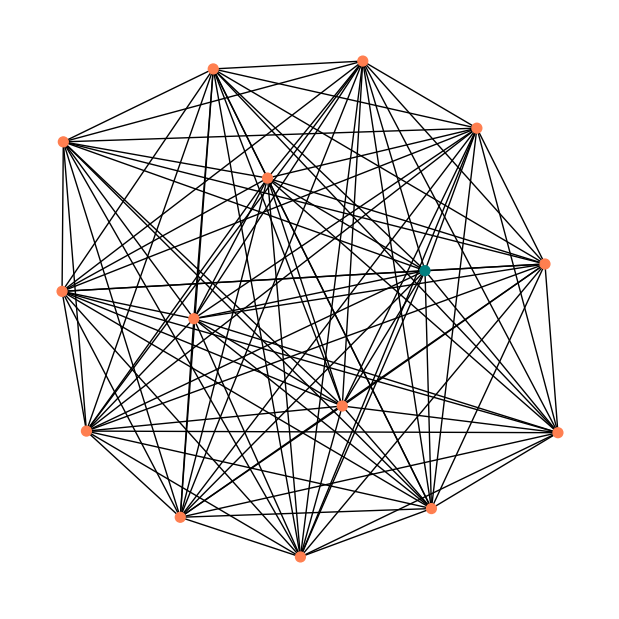

In [3]:
def plot_network(G):
    # Calculate positions and colors for nodes
    pos = nx.kamada_kawai_layout(G)
    colors = [G.nodes[n]['color'] for n in G.nodes]
    color_map = {'red': 'coral', 'blue': 'teal'}
    node_colors = [color_map[color] for color in colors]
    # Create figs directory if it does not exist
    if not os.path.exists('figs'):
        os.makedirs('figs')
    # Create a figure for the network
    fig = plt.figure(figsize=(6, 6))
    # Plot the network
    nx.draw(G, pos, node_color=node_colors, node_size=50, with_labels=False)
    
    # Add title to the left of the figure with a larger font size
    #fig.suptitle(f"The Elegant Network with Assortativity: {assortativity:.2f}", fontsize=24, x=0.05, ha='left')
    
    # Save the figure
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = os.path.join('figs', f'network_{timestamp}.pdf')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

g = subgraphs_by_size[14]
plot_network(g)

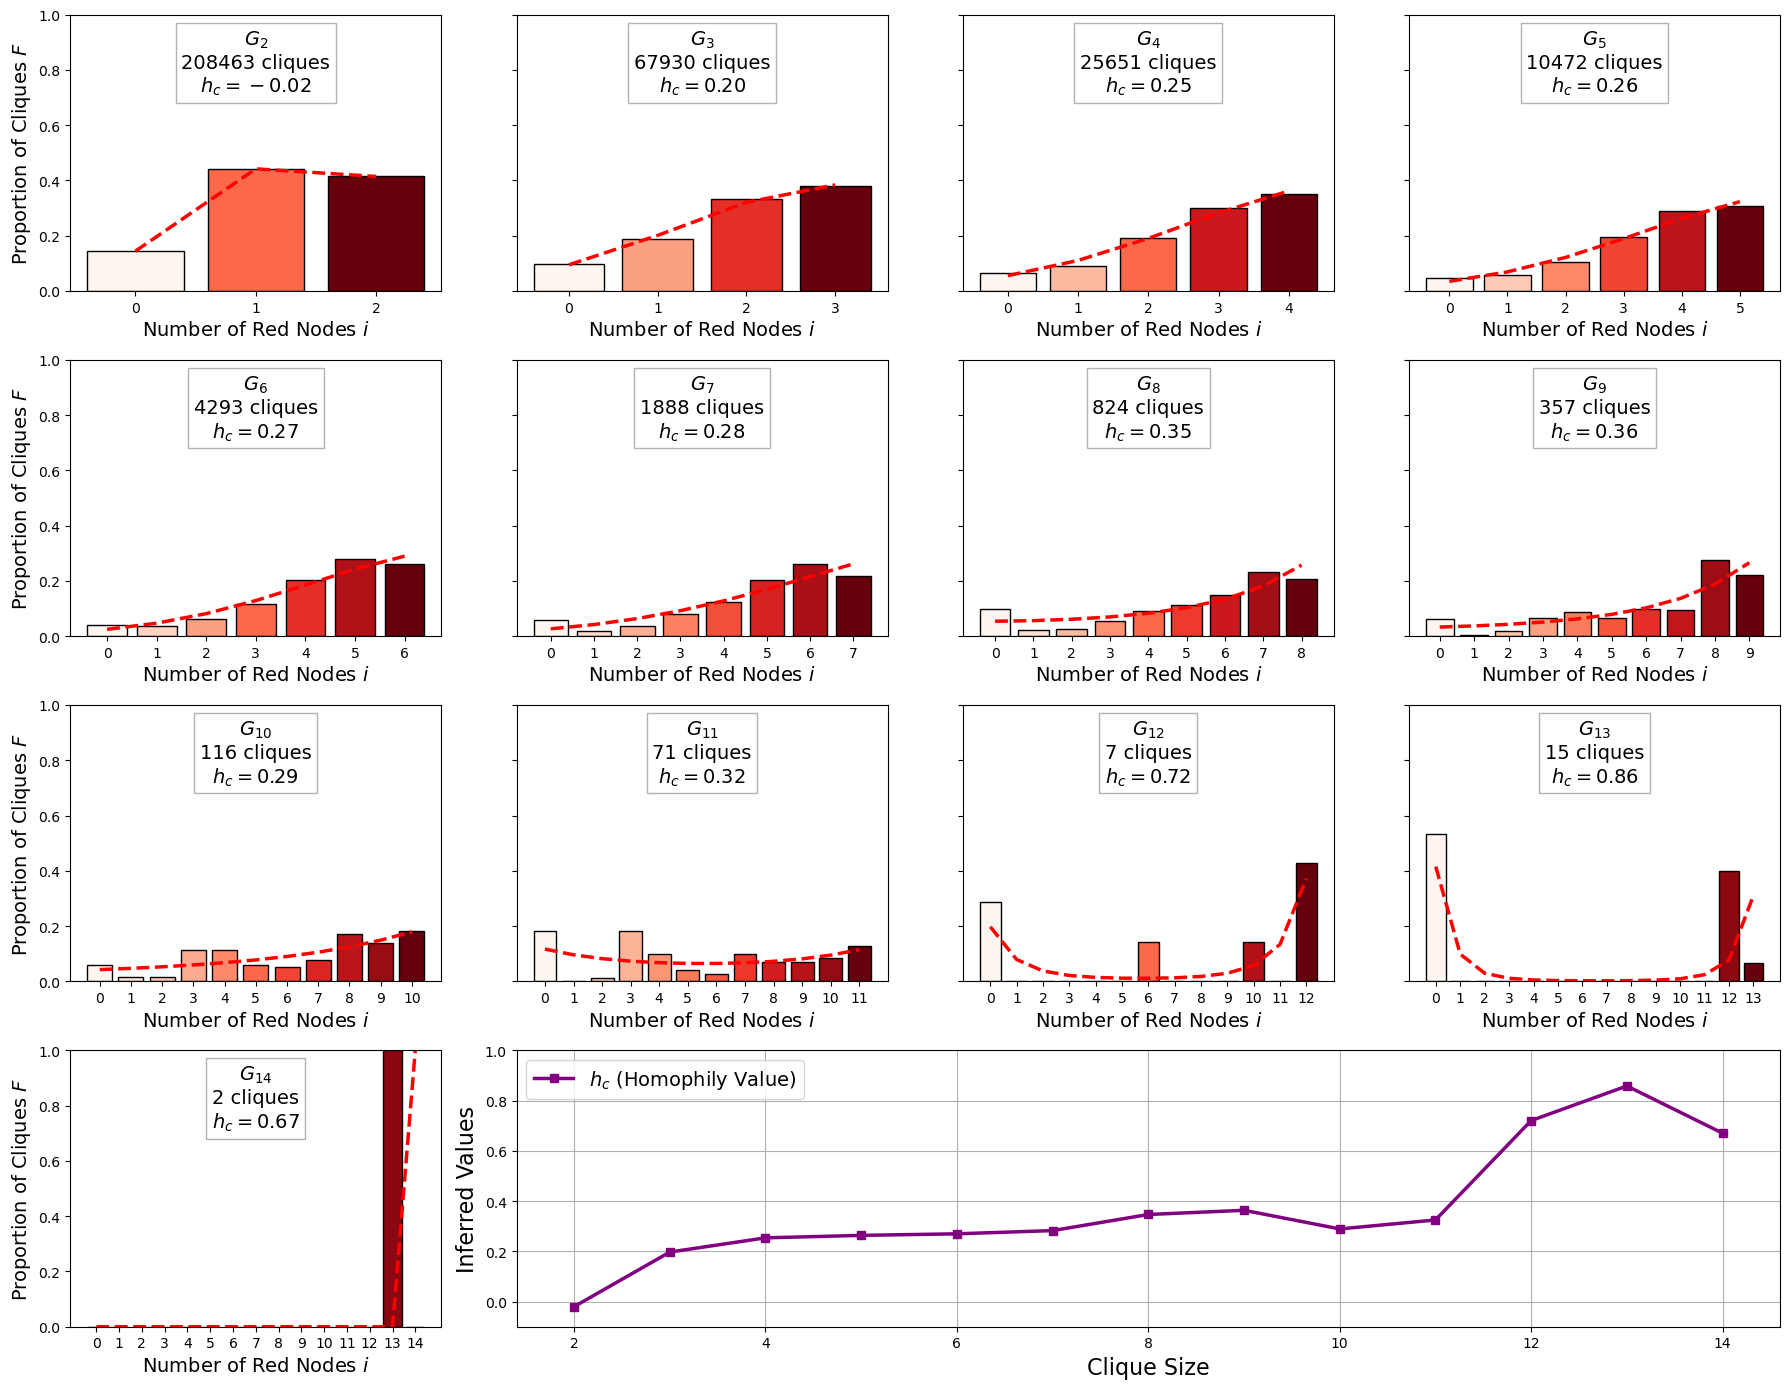

In [3]:
# Fractions of red and blue nodes
n_r = Nr / N
n_b = Nb / N

# Function to compute the partition function Z
def partition_function(theta1, theta2, h_c_i, c):
    Z = sum(np.exp(theta1 * i + theta2 * h_c_i[i]) for i in range(c + 1))
    return Z

# Function to compute the maximum entropy distribution F using inferred parameters
def compute_max_entropy_distribution(theta1, theta2, h_c_i, c):
    Z = partition_function(theta1, theta2, h_c_i, c)
    F = [np.exp(theta1 * i + theta2 * h_c_i[i]) / Z for i in range(c + 1)]
    return F

# Function to compute the homophily value h_c
def compute_homophily_value(F, c, n_r, n_b):
    h_c = 0
    for i in range(c + 1):
        clique_homophily = (2 / (c * (c - 1))) * (i**2 - c * i + (c**2 - c) / 2)
        h_c_contribution = (clique_homophily - (n_r**2 + n_b**2)) / (1 - (n_r**2 + n_b**2))
        h_c += F[i] * h_c_contribution
    return h_c

# Define h_c_i as the number of intra-group edges for cliques of size c
def compute_h_c_i(c):
    h_c_i = []
    for i in range(c + 1):
        red_edges = comb(i, 2)  # Number of red-red edges
        blue_edges = comb(c - i, 2)  # Number of blue-blue edges
        h_c_i.append(red_edges + blue_edges)
    return h_c_i

# Function to compute clique homophily distributions
def compute_clique_homophily_distributions(subgraphs_by_size, cliques_by_size, n_r, n_b):
    distributions = {}
    homophily_values = {}

    for size, subgraph in subgraphs_by_size.items():
        F = [0] * (size + 1)
        for clique in cliques_by_size[size]:
            red_node_count = sum(1 for node in clique if subgraph.nodes[node].get('color') == 'red')
            F[red_node_count] += 1
        total_cliques = sum(F)
        if total_cliques > 0:
            F = [count / total_cliques for count in F]
        distributions[size] = (F, total_cliques)  # Store both the distribution and the total number of cliques

        # Calculate the homophily value h_c
        h_c = compute_homophily_value(F, size, n_r, n_b)
        homophily_values[size] = max(-1, min(1, h_c))  # Ensure the homophily value is bounded between -1 and 1

    return distributions, homophily_values


# Function to compute the expected values of red nodes and homophily
def expected_values(theta1, theta2, h_c_i, c):
    Z = partition_function(theta1, theta2, h_c_i, c)
    F = [np.exp(theta1 * i + theta2 * h_c_i[i]) / Z for i in range(c + 1)]
    expected_red_nodes = sum(i * F[i] for i in range(c + 1)) / c
    expected_homophily = sum(h_c_i[i] * F[i] for i in range(c + 1))
    return expected_red_nodes, expected_homophily

# Objective function for optimization
def objective(params, N_r, h_c, h_c_i, c):
    theta1, theta2 = params
    expected_red_nodes, expected_homophily = expected_values(theta1, theta2, h_c_i, c)
    # Minimize the difference between empirical and expected values
    return (expected_red_nodes - N_r) ** 2 + (expected_homophily - h_c) ** 2

# Define h_c_i as the number of intra-group edges for cliques of size c
def compute_h_c_i(c):
    h_c_i = []
    for i in range(c + 1):
        red_edges = comb(i, 2)  # Number of red-red edges
        blue_edges = comb(c - i, 2)  # Number of blue-blue edges
        h_c_i.append(red_edges + blue_edges)
    return h_c_i


# Function to plot clique homophily distributions with inferred maximum entropy distributions
def plot_clique_homophily_distributions(distributions, homophily_values, inferred_params, filename="clique_homophily_distribution.pdf"):
    # Create a custom grid with GridSpec (4x4 layout)
    fig = plt.figure(figsize=(18, 14))
    gs = GridSpec(4, 4, figure=fig, height_ratios=[1, 1, 1, 1])  # Keep the 4x4 grid layout

    cmap = colormaps['Reds']

    # Create the 13 subplots for clique distributions
    for i, size in enumerate(range(2, 15)):
        ax = fig.add_subplot(gs[i // 4, i % 4])  # Position the subplot
        F, total_cliques = distributions.get(size, ([], 0))  # Get distribution and total number of cliques
        h_c = homophily_values[size]  # Get the homophily value for this clique size
        x = np.arange(len(F))  # Integer values for x-axis
        
        # Calculate color intensity based on the proportion of red nodes
        colors = [cmap(red_count / size) for red_count in x]
        
        # Plot empirical distribution as bar plot
        ax.bar(x, F, color=colors, edgecolor='black')
        
        # Compute and plot the inferred maximum entropy distribution as a red dashed line
        if size in inferred_params:
            theta1, theta2 = inferred_params[size]
            h_c_i = compute_h_c_i(size)
            F_max_entropy = compute_max_entropy_distribution(theta1, theta2, h_c_i, size)
            ax.plot(x, F_max_entropy, 'r--', label="Max Entropy F", linewidth=2.5)

        # Position the title inside the plot area, including homophily value
        ax.text(0.5, 0.95, f'$G_{{{size}}}$\n{total_cliques} cliques\n$h_c={h_c:.2f}$',
                horizontalalignment='center', verticalalignment='top',
                transform=ax.transAxes, fontsize=14, bbox=dict(facecolor='white', alpha=0.3))
        
        ax.set_ylim(0, 1)  # Set y-axis limits to ensure all plots have the same scale
        
        # Set x-axis label and ticks for all plots
        ax.set_xlabel('Number of Red Nodes $i$', fontsize=14)
        ax.set_xticks(np.arange(0, max(x) + 1))  # Ensure x-axis ticks are at integer positions
        
        # Set y-axis label for the first column, hide for others
        if i % 4 == 0:  # First column of plots
            ax.set_ylabel('Proportion of Cliques $F$', fontsize=14)
        else:
            ax.set_yticklabels([])  # Hide y-axis labels for other columns

    # Plot the inferred homophily values in the empty space (spanning the last three columns of the last row)
    ax_last = fig.add_subplot(gs[3, 1:4])  # Span the last three slots in the grid
    theta1_values = [inferred_params[c][0] for c in inferred_params]
    theta2_values = [inferred_params[c][1] for c in inferred_params]
    homophily_values_list = [homophily_values[c] for c in inferred_params]

    # Plot homophily values
    ax_last.plot(inferred_params.keys(), homophily_values_list, label=r'$h_c$ (Homophily Value)', marker='s', color = 'purple', linewidth=2.5)
    
    ax_last.set_xlabel('Clique Size', fontsize=16)
    ax_last.set_ylabel('Inferred Values', fontsize=16)
    ax_last.set_ylim(-.1, 1)  # Set y-axis limits between -1 and 1
    ax_last.legend(fontsize=14)
    ax_last.grid(True)

    plt.tight_layout()
    plt.savefig(filename)  # Save the figure
    plt.show()

distributions, homophily_values = compute_clique_homophily_distributions(subgraphs_by_size, cliques_by_size, n_r, n_b)

# Inference for each clique size
inferred_params = {}
for c in range(2, 15):
    if c in cliques_by_size and len(cliques_by_size[c]) > 0:
        # Empirical values from the computed distribution
        F, total_cliques = distributions[c]
        N_r_empirical = sum(i * F[i] for i in range(c + 1)) / c
        h_c_empirical = sum(compute_h_c_i(c)[i] * F[i] for i in range(c + 1))
        
        # Compute h_c_i for the given clique size
        h_c_i = compute_h_c_i(c)
        
        # Initial guess for theta1 and theta2
        initial_guess = [0, 0]
        
        # Optimize to find theta1 and theta2
        result = minimize(objective, initial_guess, args=(N_r_empirical, h_c_empirical, h_c_i, c))
        inferred_params[c] = result.x

# Plot the results with inferred distributions and the extra panel
plot_clique_homophily_distributions(distributions, homophily_values, inferred_params)

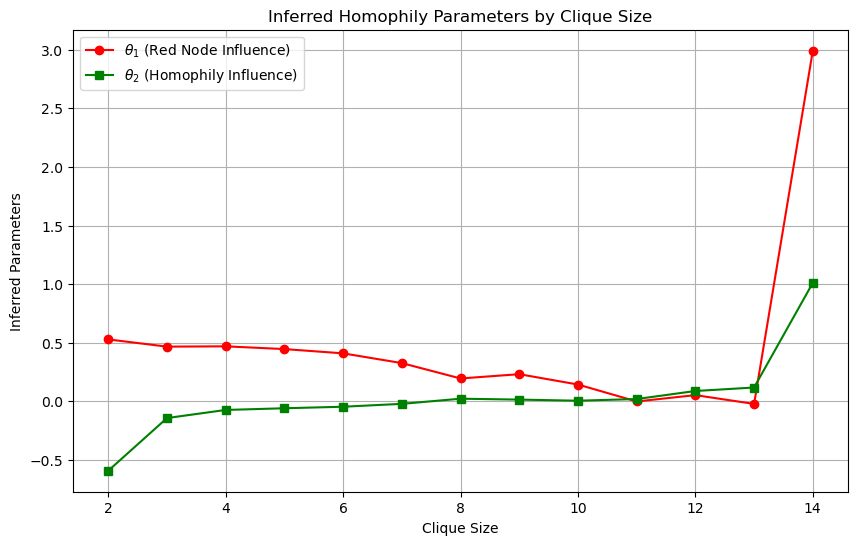

In [5]:
# Plot the inferred homophily values
theta1_values = [inferred_params[c][0] for c in inferred_params]
theta2_values = [inferred_params[c][1] for c in inferred_params]

plt.figure(figsize=(10, 6))
plt.plot(inferred_params.keys(), theta1_values, label=r'$\theta_1$ (Red Node Influence)', marker='o', color = 'red')
plt.plot(inferred_params.keys(), theta2_values, label=r'$\theta_2$ (Homophily Influence)', marker='s', color = 'green')
plt.xlabel('Clique Size')
plt.ylabel('Inferred Parameters')
plt.title('Inferred Homophily Parameters by Clique Size')
plt.legend()
plt.grid(True)
plt.show()

188672 nodes
68.30% red nodes and 31.70% blue nodes


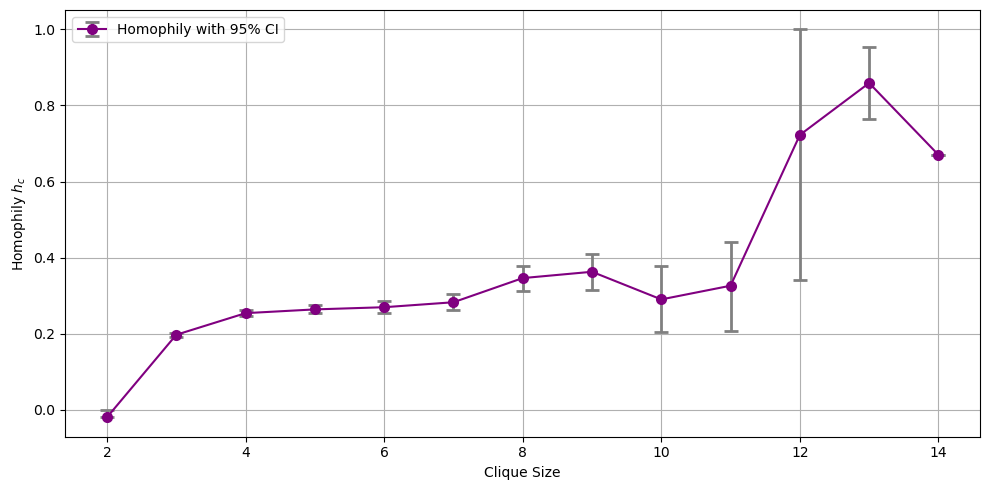

In [10]:
# Function to compute intra-group edges for cliques of size c
def compute_h_c_i(c):
    h_c_i = []
    for i in range(c + 1):
        red_edges = comb(i, 2)  # Red-red edges
        blue_edges = comb(c - i, 2)  # Blue-blue edges
        h_c_i.append(red_edges + blue_edges)
    return h_c_i

# Function to compute the homophily value
def compute_homophily_value(F, c, n_r, n_b):
    h_c = 0
    for i in range(c + 1):
        clique_homophily = (2 / (c * (c - 1))) * (i**2 - c * i + (c**2 - c) / 2)
        h_c_contribution = (clique_homophily - (n_r**2 + n_b**2)) / (1 - (n_r**2 + n_b**2))
        h_c += F[i] * h_c_contribution
    return h_c

# Function to compute clique homophily distributions
def compute_clique_homophily_distributions(subgraphs_by_size, cliques_by_size, n_r, n_b):
    distributions = {}
    homophily_values = {}
    total_cliques_by_size = {}

    for size, subgraph in subgraphs_by_size.items():
        F = [0] * (size + 1)
        for clique in cliques_by_size[size]:
            red_node_count = sum(1 for node in clique if subgraph.nodes[node].get('color') == 'red')
            F[red_node_count] += 1
        total_cliques = sum(F)
        total_cliques_by_size[size] = total_cliques
        if total_cliques > 0:
            F = [count / total_cliques for count in F]
        distributions[size] = F

        h_c = compute_homophily_value(F, size, n_r, n_b)
        homophily_values[size] = max(-1, min(1, h_c))

    return distributions, homophily_values, total_cliques_by_size

# Objective function for optimization
def objective(params, N_r, h_c, h_c_i, c):
    theta1, theta2 = params
    expected_red_nodes, expected_homophily = expected_values(theta1, theta2, h_c_i, c)
    return (expected_red_nodes - N_r) ** 2 + (expected_homophily - h_c) ** 2

# Function to compute the expected values of red nodes and homophily
def expected_values(theta1, theta2, h_c_i, c):
    max_exponent = max(theta1 * i + theta2 * h_c_i[i] for i in range(c + 1))  # Find the maximum exponent value
    Z = partition_function(theta1, theta2, h_c_i, c, max_exponent)
    F = [np.exp(theta1 * i + theta2 * h_c_i[i] - max_exponent) / Z for i in range(c + 1)]  # Subtract max_exponent
    expected_red_nodes = sum(i * F[i] for i in range(c + 1)) / c
    expected_homophily = sum(h_c_i[i] * F[i] for i in range(c + 1))
    return expected_red_nodes, expected_homophily

# Updated partition function to handle max_exponent
def partition_function(theta1, theta2, h_c_i, c, max_exponent=0):
    Z = sum(np.exp(theta1 * i + theta2 * h_c_i[i] - max_exponent) for i in range(c + 1))  # Subtract max_exponent
    return Z

# Function to perform bootstrap resampling and compute confidence intervals
def bootstrap_homophily(F, c, n_c, n_r, n_b, num_bootstrap=1000, ci=95):
    h_values = []
    for _ in range(num_bootstrap):
        # Resample n_c cliques according to empirical distribution F
        resampled_counts = np.random.choice(range(c + 1), size=n_c, p=F)
        # Compute new empirical distribution F_bootstrap
        counts = np.bincount(resampled_counts, minlength=c + 1)
        F_bootstrap = counts / n_c
        # Compute homophily value for resampled data
        h_c_bootstrap = compute_homophily_value(F_bootstrap, c, n_r, n_b)
        h_values.append(h_c_bootstrap)

    # Compute mean and confidence intervals
    h_mean = np.mean(h_values)
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    h_lower = np.percentile(h_values, lower_percentile)
    h_upper = np.percentile(h_values, upper_percentile)

    return h_mean, h_lower, h_upper
# Main function to compute everything and plot the homophily vs clique size curve with confidence intervals
def plot_homophily_vs_clique_size_with_bootstrap(G, num_bootstrap=1000,  fig_name='boot'):
    """
    Compute and plot homophily vs. clique size with confidence intervals from the network G.

    Parameters:
    G (networkx.Graph): The input graph.
    filename (str): Path to save the plot.
    num_bootstrap (int): Number of bootstrap iterations.
    """

    filename = "figs/homophily_vs_clique_size_"+fig_name+"_.pdf"
    # Ensure the directory 'figs' exists
    if not os.path.exists('figs'):
        os.makedirs('figs')

    N = len(G)
    Nr = sum(1 for node, data in G.nodes(data=True) if data.get('color') == 'red')
    Nb = N - Nr
    n_r = Nr / N
    n_b = Nb / N

    print(f"{N} nodes")
    print(f"{n_r * 100:.2f}% red nodes and {n_b * 100:.2f}% blue nodes")

    # Detect cliques in the graph
    maximal_cliques = list(nx.find_cliques(G))
    clique_sizes = [len(clique) for clique in maximal_cliques]
    clique_sizes_set = set(clique_sizes)

    # Group cliques by their size
    cliques_by_size = {size: [] for size in clique_sizes_set}
    for clique in maximal_cliques:
        clique_size = len(clique)
        if clique_size in clique_sizes_set:
            cliques_by_size[clique_size].append(clique)

    # Create subgraphs for each clique size
    subgraphs_by_size = {}
    for size, cliques in cliques_by_size.items():
        subgraph = nx.Graph()
        for clique in cliques:
            subgraph.add_edges_from([(clique[i], clique[j]) for i in range(len(clique)) for j in range(i + 1, len(clique))])
            for node in clique:
                if node in G.nodes:
                    subgraph.nodes[node].update(G.nodes[node])
        subgraphs_by_size[size] = subgraph

    # Compute distributions and homophily values
    distributions, homophily_values, total_cliques_by_size = compute_clique_homophily_distributions(
        subgraphs_by_size, cliques_by_size, n_r, n_b)

    # Perform bootstrap for each clique size to get confidence intervals
    homophily_means = {}
    homophily_lowers = {}
    homophily_uppers = {}

    for c in sorted(clique_sizes_set):
        F = distributions[c]
        n_c = total_cliques_by_size[c]
        if n_c > 0:
            h_mean, h_lower, h_upper = bootstrap_homophily(F, c, n_c, n_r, n_b, num_bootstrap=num_bootstrap)
            homophily_means[c] = h_mean
            homophily_lowers[c] = max(0, h_lower)  # Ensure non-negative values
            homophily_uppers[c] = max(0, h_upper)  # Ensure non-negative values
        else:
            homophily_means[c] = homophily_values[c]
            homophily_lowers[c] = homophily_values[c]
            homophily_uppers[c] = homophily_values[c]

    # Plot homophily vs clique size with error bars
    plt.figure(figsize=(10, 5))
    clique_sizes = sorted(clique_sizes_set)
    homophily_values_list = [homophily_means[c] for c in clique_sizes]
    error_lower = [homophily_means[c] - homophily_lowers[c] for c in clique_sizes]
    error_upper = [homophily_uppers[c] - homophily_means[c] for c in clique_sizes]

    # Ensure error values are non-negative
    error_lower = [max(0, el) for el in error_lower]
    error_upper = [max(0, eu) for eu in error_upper]
    error = [error_lower, error_upper]

    plt.errorbar(clique_sizes, homophily_values_list, yerr=error, fmt='o-', color='purple', ecolor='gray',
                 capsize=5, elinewidth=2, markeredgewidth=2, label='Homophily with 95% CI')

    plt.xlabel('Clique Size')
    plt.ylabel('Homophily $h_c$')
    #plt.title('Homophily vs Clique Size with Confidence Intervals')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_homophily_vs_clique_size_with_bootstrap(G, fig_name='last_fm')